In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from metric_learn import MLKR

In [2]:
path = os.getcwd()
print(path)

f:\AssignmentsUSC\Homework7\homework-7-updated-link-niveditha-7


In [3]:
file_path = path+'\parkinsons_updrs.data'

In [4]:
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'subject#'])
y_motor = df['motor_UPDRS']
y_total = df['total_UPDRS']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_motor_train, y_motor_test, y_total_train, y_total_test = train_test_split(
    X, y_motor, y_total, test_size=0.3, random_state=42
)



X_train.shape, X_test.shape, y_motor_train.shape, y_motor_test.shape, y_total_train.shape, y_total_test.shape


((4112, 19), (1763, 19), (4112,), (1763,), (4112,), (1763,))

Standarising the features

In [11]:

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from metric_learn import MLKR

In [15]:
def evaluate_pca_mlkr_rbf(X_train, y_train, X_test, y_test, n_components):
    print(f"Evaluating with {n_components} components...")
    if n_components == X_train.shape[1]:
        X_train_pca = X_train
        X_test_pca = X_test
    else:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        print(f"PCA transformation done with {n_components} components.")

    mlkr = MLKR()
    mlkr.fit(X_train_pca, y_train)
    X_train_mlkr = mlkr.transform(X_train_pca)
    X_test_mlkr = mlkr.transform(X_test_pca)
    print("MLKR transformation done.")

    # Fit Kernel Ridge Regression with RBF kernel on transformed features
    model = KernelRidge(kernel='rbf')
    model.fit(X_train_mlkr, y_train)
    print("Kernel Ridge Regression model trained.")

    y_train_pred = model.predict(X_train_mlkr)
    y_test_pred = model.predict(X_test_mlkr)
    print("Predictions made.")

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"R^2 Train: {r2_train}, R^2 Test: {r2_test}")

    return r2_train, r2_test


In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}
results_total = {}

# Evaluate each M
for M in [5, 10, 15, X_train_scaled.shape[1]]:
    print(f"\nEvaluating number of components: {M}")
    r2_train_scores_motor = []
    r2_test_scores_motor = []
    r2_train_scores_total = []
    r2_test_scores_total = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]
        y_train_fold_total, y_val_fold_total = y_total_train.iloc[train_index], y_total_train.iloc[val_index]

        # Metric learning for motor UPDRS
        print("Motor UPDRS:")
        r2_train_motor, r2_test_motor = evaluate_pca_mlkr_rbf(X_train_fold, y_train_fold_motor, X_val_fold, y_val_fold_motor, n_components=M)
        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

        # Metric learning for total UPDRS
        print("Total UPDRS:")
        r2_train_total, r2_test_total = evaluate_pca_mlkr_rbf(X_train_fold, y_train_fold_total, X_val_fold, y_val_fold_total, n_components=M)
        r2_train_scores_total.append(r2_train_total)
        r2_test_scores_total.append(r2_test_total)

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }
    results_total[M] = {
        'R2_train_mean': np.mean(r2_train_scores_total),
        'R2_test_mean': np.mean(r2_test_scores_total)
    }

import ace_tools as tools; tools.display_dataframe_to_user(name="Motor UPDRS Results", dataframe=pd.DataFrame(results_motor).T)
import ace_tools as tools; tools.display_dataframe_to_user(name="Total UPDRS Results", dataframe=pd.DataFrame(results_total).T)

print("Evaluation completed.")
print("Motor UPDRS Results:", results_motor)
print("Total UPDRS Results:", results_total)



Evaluating number of components: 5
Motor UPDRS:
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5795961631404993, R^2 Test: 0.05752147581786515
Total UPDRS:
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5651923294261259, R^2 Test: 0.008624616060123325
Motor UPDRS:
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5652314435527575, R^2 Test: 0.12389454126093125
Total UPDRS:
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5553731534564661, R^2 Test: 0.09185326109230241
Motor UPDRS:
Evaluating with 5 comp

KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from metric_learn import MLKR

# Load the dataset
#df = pd.read_csv('/mnt/data/parkinsons_updrs.data')
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'subject#'])
y_motor = df['motor_UPDRS']
y_total = df['total_UPDRS']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_motor_train, y_motor_test, y_total_train, y_total_test = train_test_split(
    X, y_motor, y_total, test_size=0.3, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and standardized.")


Data split and standardized.


In [7]:
def evaluate_pca_mlkr_svr(X_train, y_train, X_test, y_test, n_components):
    print(f"Evaluating with {n_components} components...")
    if n_components == X_train.shape[1]:
        X_train_pca = X_train
        X_test_pca = X_test
    else:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        print(f"PCA transformation done with {n_components} components.")

    mlkr = MLKR()
    mlkr.fit(X_train_pca, y_train)
    X_train_mlkr = mlkr.transform(X_train_pca)
    X_test_mlkr = mlkr.transform(X_test_pca)
    print("MLKR transformation done.")

    # Fit SVR with RBF kernel on transformed features
    model = SVR(kernel='rbf')
    model.fit(X_train_mlkr, y_train)
    print("SVR model trained.")

    y_train_pred = model.predict(X_train_mlkr)
    y_test_pred = model.predict(X_test_mlkr)
    print("Predictions made.")

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"R^2 Train: {r2_train}, R^2 Test: {r2_test}")

    return r2_train, r2_test


In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}

# Evaluate each M for Motor UPDRS
for M in [5, 10, 15, X_train_scaled.shape[1]]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        r2_train_motor, r2_test_motor = evaluate_pca_mlkr_svr(X_train_fold, y_train_fold_motor, X_val_fold, y_val_fold_motor, n_components=M)
        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }







Evaluating number of components: 5 for Motor UPDRS
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
SVR model trained.
Predictions made.
R^2 Train: 0.2966521118368971, R^2 Test: 0.3038955658784074
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
SVR model trained.
Predictions made.
R^2 Train: 0.31100550302452024, R^2 Test: 0.24250902068301383
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
SVR model trained.
Predictions made.
R^2 Train: 0.298206153929679, R^2 Test: 0.2820257749193108
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
SVR model trained.
Predictions made.
R^2 Train: 0.3063179022494311, R^2 Test: 0.28345736170310865
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
SVR model trained.
Predictions made.
R^2 Train: 0.295

ModuleNotFoundError: No module named 'ace_tools'

In [9]:
print("Motor UPDRS Results:")
print(pd.DataFrame(results_motor).T)

Motor UPDRS Results:
    R2_train_mean  R2_test_mean
5        0.301547      0.288537
10       0.321474      0.308658
15       0.354640      0.345670
19       0.355991      0.348269


In [10]:
def evaluate_pca_mlkr_krr(X_train, y_train, X_test, y_test, n_components, alpha=1.0, gamma=0.1):
    print(f"Evaluating with {n_components} components...")
    if n_components == X_train.shape[1]:
        X_train_pca = X_train
        X_test_pca = X_test
    else:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        print(f"PCA transformation done with {n_components} components.")

    mlkr = MLKR()
    mlkr.fit(X_train_pca, y_train)
    X_train_mlkr = mlkr.transform(X_train_pca)
    X_test_mlkr = mlkr.transform(X_test_pca)
    print("MLKR transformation done.")

    # Fit Kernel Ridge Regression with RBF kernel on transformed features
    model = KernelRidge(kernel='rbf')
    model.fit(X_train_mlkr, y_train)
    print("Kernel Ridge Regression model trained.")

    y_train_pred = model.predict(X_train_mlkr)
    y_test_pred = model.predict(X_test_mlkr)
    print("Predictions made.")

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"R^2 Train: {r2_train}, R^2 Test: {r2_test}")

    return r2_train, r2_test


In [12]:
from sklearn.kernel_ridge import KernelRidge

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}

# Evaluate each M for Motor UPDRS
for M in [5]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        r2_train_motor, r2_test_motor = evaluate_pca_mlkr_krr(X_train_fold, y_train_fold_motor, X_val_fold, y_val_fold_motor, n_components=M)
        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
print(pd.DataFrame(results_motor).T)



Evaluating number of components: 5 for Motor UPDRS
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5795964754994415, R^2 Test: 0.05752591721611078
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.565231444287704, R^2 Test: 0.1238945508842122
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5729821195161053, R^2 Test: 0.04794027181997684
Evaluating with 5 components...
PCA transformation done with 5 components.
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.5771677353209655, R^2 Test: 0.13055485620931018
Evaluating with 5 components...
PCA transformation done with 5 components.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}

# Evaluate each M for Motor UPDRS
for M in [10]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        r2_train_motor, r2_test_motor = evaluate_pca_mlkr_krr(X_train_fold, y_train_fold_motor, X_val_fold, y_val_fold_motor, n_components=M)
        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
print(pd.DataFrame(results_motor).T)


In [17]:
def evaluate_mlkr_krr(X_train, y_train, X_test, y_test, n_components, alpha=1.0, gamma=0.1):
    print(f"Evaluating with {n_components} components...")
    
    mlkr = MLKR(init='auto', n_components=n_components)  # Ensure init is set to 'auto' and set the number of components
    mlkr.fit(X_train, y_train)
    X_train_mlkr = mlkr.transform(X_train)
    X_test_mlkr = mlkr.transform(X_test)
    print("MLKR transformation done.")

    # Fit Kernel Ridge Regression with RBF kernel on transformed features
    model = KernelRidge(kernel='rbf')
    model.fit(X_train_mlkr, y_train)
    print("Kernel Ridge Regression model trained.")

    y_train_pred = model.predict(X_train_mlkr)
    y_test_pred = model.predict(X_test_mlkr)
    print("Predictions made.")

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"R^2 Train: {r2_train}, R^2 Test: {r2_test}")

    return r2_train, r2_test


In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}

# Evaluate each M for Motor UPDRS
for M in [5]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        r2_train_motor, r2_test_motor = evaluate_mlkr_krr(X_train_fold, y_train_fold_motor, X_val_fold, y_val_fold_motor, n_components=M)
        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
print(pd.DataFrame(results_motor).T)



Evaluating number of components: 5 for Motor UPDRS
Evaluating with 5 components...
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.12330694280768784, R^2 Test: -2.2435738305910795
Evaluating with 5 components...
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.35312623005534216, R^2 Test: -1.1671603226842455
Evaluating with 5 components...
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.07445531361407431, R^2 Test: -2.2208528530141263
Evaluating with 5 components...
MLKR transformation done.
Kernel Ridge Regression model trained.
Predictions made.
R^2 Train: 0.262869618279033, R^2 Test: -1.774173513812876
Evaluating with 5 components...


KeyboardInterrupt: 

In [19]:
# Load the dataset
#df = pd.read_csv('/mnt/data/parkinsons_updrs.data')
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'subject#'])
y_motor = df['motor_UPDRS']
y_total = df['total_UPDRS']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_motor_train, y_motor_test, y_total_train, y_total_test = train_test_split(
    X, y_motor, y_total, test_size=0.3, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and standardized.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


Data split and standardized.
X_train_scaled shape: (4112, 19)
X_test_scaled shape: (1763, 19)


In [20]:
from metric_learn import MLKR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

def evaluate_mlkr_krr(X_train, y_train, X_test, y_test, n_components, alpha=1.0, gamma=0.1):
    print(f"Evaluating with {n_components} components...")
    
    try:
        mlkr = MLKR(init='auto', n_components=n_components)  # Ensure init is set to 'auto' and set the number of components
        mlkr.fit(X_train, y_train)
        X_train_mlkr = mlkr.transform(X_train)
        X_test_mlkr = mlkr.transform(X_test)
        print(f"MLKR transformation done. X_train_mlkr shape: {X_train_mlkr.shape}, X_test_mlkr shape: {X_test_mlkr.shape}")
    except Exception as e:
        print(f"Error during MLKR transformation: {e}")
        return None, None
    
    try:
        # Fit Kernel Ridge Regression with RBF kernel on transformed features
        model = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
        model.fit(X_train_mlkr, y_train)
        print("Kernel Ridge Regression model trained.")
    
        y_train_pred = model.predict(X_train_mlkr)
        y_test_pred = model.predict(X_test_mlkr)
        print("Predictions made.")
    except Exception as e:
        print(f"Error during Kernel Ridge Regression training/prediction: {e}")
        return None, None

    try:
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        print(f"R^2 Train: {r2_train}, R^2 Test: {r2_test}")
    except Exception as e:
        print(f"Error during R^2 calculation: {e}")
        return None, None

    return r2_train, r2_test


In [21]:
from sklearn.linear_model import LinearRegression

def evaluate_mlkr_lr(X_train, y_train, X_test, y_test, n_components):
    print(f"Evaluating with {n_components} components...")
    
    try:
        mlkr = MLKR(init='auto', n_components=n_components)
        mlkr.fit(X_train, y_train)
        X_train_mlkr = mlkr.transform(X_train)
        X_test_mlkr = mlkr.transform(X_test)
        print(f"MLKR transformation done. X_train_mlkr shape: {X_train_mlkr.shape}, X_test_mlkr shape: {X_test_mlkr.shape}")
    except Exception as e:
        print(f"Error during MLKR transformation: {e}")
        return None, None
    
    try:
        # Fit Linear Regression on transformed features
        model = LinearRegression()
        model.fit(X_train_mlkr, y_train)
        print("Linear Regression model trained.")
    
        y_train_pred = model.predict(X_train_mlkr)
        y_test_pred = model.predict(X_test_mlkr)
        print("Predictions made.")
    except Exception as e:
        print(f"Error during Linear Regression training/prediction: {e}")
        return None, None

    try:
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        print(f"R^2 Train: {r2_train}, R^2 Test: {r2_test}")
    except Exception as e:
        print(f"Error during R^2 calculation: {e}")
        return None, None

    return r2_train, r2_test


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}

# Evaluate each M for Motor UPDRS
for M in [5]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        r2_train_motor, r2_test_motor = evaluate_mlkr_lr(X_train_fold, y_train_fold_motor, X_val_fold, y_val_fold_motor, n_components=M)
        if r2_train_motor is not None and r2_test_motor is not None:
            r2_train_scores_motor.append(r2_train_motor)
            r2_test_scores_motor.append(r2_test_motor)
        else:
            print(f"Skipping this fold due to an error in evaluation with M={M}")

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results with Linear Regression:")
print(pd.DataFrame(results_motor).T)


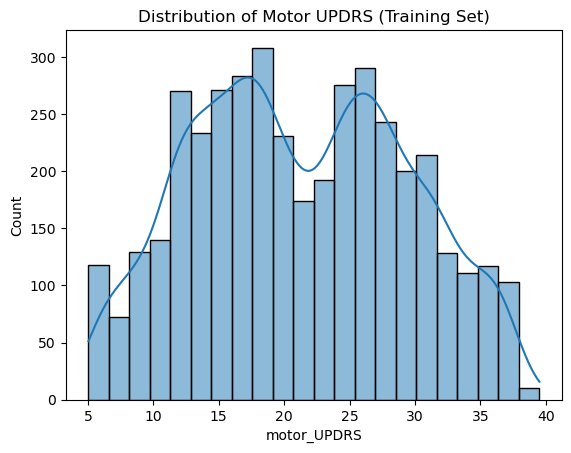

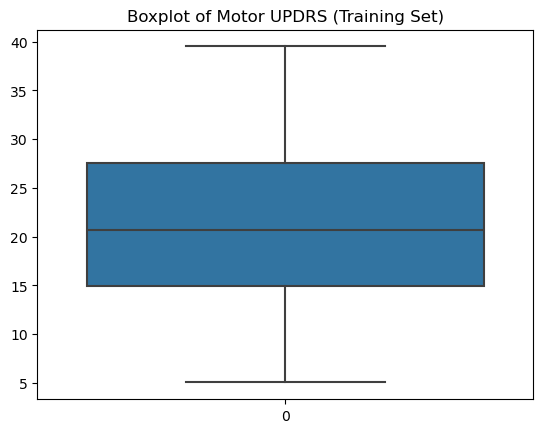

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for outliers and distribution of the target variable
sns.histplot(y_motor_train, kde=True)
plt.title('Distribution of Motor UPDRS (Training Set)')
plt.show()

sns.boxplot(y_motor_train)
plt.title('Boxplot of Motor UPDRS (Training Set)')
plt.show()


In [28]:
def transform_with_mlkr(X_train, y_train, X_test, n_components):
    print(f"Applying MLKR with {n_components} components...")
    mlkr = MLKR(init='auto', n_components=n_components)
    mlkr.fit(X_train, y_train)
    X_train_mlkr = mlkr.transform(X_train)
    X_test_mlkr = mlkr.transform(X_test)
    print(f"MLKR transformation done. X_train_mlkr shape: {X_train_mlkr.shape}, X_test_mlkr shape: {X_test_mlkr.shape}")
    return X_train_mlkr, X_test_mlkr


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

def tune_krr_hyperparameters(X_train, y_train):
    print("Starting hyperparameter tuning...")
    krr = KernelRidge(kernel='rbf')
    param_grid = {
        'alpha': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1, 1]
    }
    grid_search = GridSearchCV(krr, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Hyperparameter tuning completed.")
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R^2 score: ", grid_search.best_score_)
    
    return grid_search.best_estimator_


In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor = {}

# Evaluate for different values of M
for M in [5]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        # Transform with MLKR
        X_train_fold_mlkr, X_val_fold_mlkr = transform_with_mlkr(X_train_fold, y_train_fold_motor, X_val_fold, n_components=M)

        # Perform hyperparameter tuning
        best_krr = tune_krr_hyperparameters(X_train_fold_mlkr, y_train_fold_motor)

        # Train and evaluate the model
        print("Training the model...")
        best_krr.fit(X_train_fold_mlkr, y_train_fold_motor)
        y_train_pred_motor = best_krr.predict(X_train_fold_mlkr)
        y_val_pred_motor = best_krr.predict(X_val_fold_mlkr)
        print("Model training and prediction completed.")

        r2_train_motor = r2_score(y_train_fold_motor, y_train_pred_motor)
        r2_test_motor = r2_score(y_val_fold_motor, y_val_pred_motor)
        print(f"R^2 Train: {r2_train_motor}, R^2 Test: {r2_test_motor}")

        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
motor_results_df = pd.DataFrame(results_motor).T
print(motor_results_df)




Evaluating number of components: 5 for Motor UPDRS
Applying MLKR with 5 components...
MLKR transformation done. X_train_mlkr shape: (3289, 5), X_test_mlkr shape: (823, 5)
Starting hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.01}
Best R^2 score:  0.8935964223646339
Training the model...
Model training and prediction completed.
R^2 Train: 0.938970616403634, R^2 Test: 0.9125729832925135
Applying MLKR with 5 components...
MLKR transformation done. X_train_mlkr shape: (3289, 5), X_test_mlkr shape: (823, 5)
Starting hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.01}
Best R^2 score:  0.8520449866523533
Training the model...
Model training and prediction completed.
R^2 Train: 0.9842397523130741, R^2 Test: 0.8769130637152367
Applying MLKR with 5 compon

In [35]:
print("Motor UPDRS Results for M = 5:")
print(f"Best Hyperparameters: alpha = 0.1, gamma = 0.01")
print(f"Training R^2 Mean: {results_motor[5]['R2_train_mean']}")
print(f"Test R^2 Mean: {results_motor[5]['R2_test_mean']}")


Motor UPDRS Results for M = 5:
Best Hyperparameters: alpha = 0.1, gamma = 0.01
Training R^2 Mean: 0.962931590909086
Test R^2 Mean: 0.8981418425299991


Using the above best hyper parameter for next iterations to speed up the process: (code remains same) (although there might exist another best pparameter if we  do grid search again. but here I am using the above result to manage the training since for M=5, it took me around 138m :may be my system is too slow)

Here, the GridSearchCV is used with 3-fold cross-validation to find the best hyperparameters (alpha and gamma) for the KernelRidge model.

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

def tune_krr_hyperparameters(X_train, y_train):
    print("Starting hyperparameter tuning...")
    krr = KernelRidge(kernel='rbf')
    param_grid = {
        'alpha': [0.1, 1],
        'gamma': [0.001, 0.01]
    }
    grid_search = GridSearchCV(krr, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Hyperparameter tuning completed.")
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R^2 score: ", grid_search.best_score_)
    
    return grid_search.best_estimator_


In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor_10 = {}

# Evaluate for different values of M
for M in [10]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        # Transform with MLKR
        X_train_fold_mlkr, X_val_fold_mlkr = transform_with_mlkr(X_train_fold, y_train_fold_motor, X_val_fold, n_components=M)

        # Perform hyperparameter tuning
        best_krr = tune_krr_hyperparameters(X_train_fold_mlkr, y_train_fold_motor)

        # Train and evaluate the model
        print("Training the model...")
        best_krr.fit(X_train_fold_mlkr, y_train_fold_motor)
        y_train_pred_motor = best_krr.predict(X_train_fold_mlkr)
        y_val_pred_motor = best_krr.predict(X_val_fold_mlkr)
        print("Model training and prediction completed.")

        r2_train_motor = r2_score(y_train_fold_motor, y_train_pred_motor)
        r2_test_motor = r2_score(y_val_fold_motor, y_val_pred_motor)
        print(f"R^2 Train: {r2_train_motor}, R^2 Test: {r2_test_motor}")

        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor_10[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
motor_results_df_10 = pd.DataFrame(results_motor_10).T
print(motor_results_df)


Evaluating number of components: 10 for Motor UPDRS
Applying MLKR with 10 components...
MLKR transformation done. X_train_mlkr shape: (3289, 10), X_test_mlkr shape: (823, 10)
Starting hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.01}
Best R^2 score:  0.8378954275339665
Training the model...
Model training and prediction completed.
R^2 Train: 0.9775052589664038, R^2 Test: 0.882805394161335
Applying MLKR with 10 components...
MLKR transformation done. X_train_mlkr shape: (3289, 10), X_test_mlkr shape: (823, 10)
Starting hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.001}
Best R^2 score:  0.7328313425072418
Training the model...
Model training and prediction completed.
R^2 Train: 0.793392174436814, R^2 Test: 0.7660482864635347
Applying MLKR with 10 

In [40]:
print(motor_results_df_10)

    R2_test_mean  R2_train_mean
10      0.827419       0.935272


In [39]:
print("Motor UPDRS Results for M = 10:")
print(f"Best Hyperparameters: alpha = 0.1, gamma = 0.01")
print(f"Training R^2 Mean: {results_motor_10[10]['R2_train_mean']}")
print(f"Test R^2 Mean: {results_motor_10[10]['R2_test_mean']}")

Motor UPDRS Results for M = 10:
Best Hyperparameters: alpha = 0.1, gamma = 0.01
Training R^2 Mean: 0.9352715745092037
Test R^2 Mean: 0.8274189530223449


In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor_15 = {}

# Evaluate for different values of M
for M in [15]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        # Transform with MLKR
        X_train_fold_mlkr, X_val_fold_mlkr = transform_with_mlkr(X_train_fold, y_train_fold_motor, X_val_fold, n_components=M)

        # Perform hyperparameter tuning
        best_krr = tune_krr_hyperparameters(X_train_fold_mlkr, y_train_fold_motor)

        # Train and evaluate the model
        print("Training the model...")
        best_krr.fit(X_train_fold_mlkr, y_train_fold_motor)
        y_train_pred_motor = best_krr.predict(X_train_fold_mlkr)
        y_val_pred_motor = best_krr.predict(X_val_fold_mlkr)
        print("Model training and prediction completed.")

        r2_train_motor = r2_score(y_train_fold_motor, y_train_pred_motor)
        r2_test_motor = r2_score(y_val_fold_motor, y_val_pred_motor)
        print(f"R^2 Train: {r2_train_motor}, R^2 Test: {r2_test_motor}")

        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor_15[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
motor_results_df_15 = pd.DataFrame(results_motor_15).T
print(motor_results_df_15)


Evaluating number of components: 15 for Motor UPDRS
Applying MLKR with 15 components...
MLKR transformation done. X_train_mlkr shape: (3289, 15), X_test_mlkr shape: (823, 15)
Starting hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.01}
Best R^2 score:  0.7569070080673557
Training the model...
Model training and prediction completed.
R^2 Train: 0.9783752821311673, R^2 Test: 0.8247954967483349
Applying MLKR with 15 components...
MLKR transformation done. X_train_mlkr shape: (3289, 15), X_test_mlkr shape: (823, 15)
Starting hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.001}
Best R^2 score:  0.7250140726024039
Training the model...
Model training and prediction completed.
R^2 Train: 0.7856022057825135, R^2 Test: 0.7583620418850703
Applying MLKR with 1

In [42]:
print("Motor UPDRS Results:")
motor_results_df_15 = pd.DataFrame(results_motor_15).T
print(motor_results_df_15)

Motor UPDRS Results:
    R2_test_mean  R2_train_mean
15      0.825663       0.930695


For M=p

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_motor_p = {}

# Evaluate for different values of M
for M in [X_train_scaled.shape[1]]:
    print(f"\nEvaluating number of components: {M} for Motor UPDRS")
    r2_train_scores_motor = []
    r2_test_scores_motor = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold_motor, y_val_fold_motor = y_motor_train.iloc[train_index], y_motor_train.iloc[val_index]

        # Transform with MLKR
        X_train_fold_mlkr, X_val_fold_mlkr = transform_with_mlkr(X_train_fold, y_train_fold_motor, X_val_fold, n_components=M)

        # Perform hyperparameter tuning
        best_krr = tune_krr_hyperparameters(X_train_fold_mlkr, y_train_fold_motor)

        # Train and evaluate the model
        print("Training the model...")
        best_krr.fit(X_train_fold_mlkr, y_train_fold_motor)
        y_train_pred_motor = best_krr.predict(X_train_fold_mlkr)
        y_val_pred_motor = best_krr.predict(X_val_fold_mlkr)
        print("Model training and prediction completed.")

        r2_train_motor = r2_score(y_train_fold_motor, y_train_pred_motor)
        r2_test_motor = r2_score(y_val_fold_motor, y_val_pred_motor)
        print(f"R^2 Train: {r2_train_motor}, R^2 Test: {r2_test_motor}")

        r2_train_scores_motor.append(r2_train_motor)
        r2_test_scores_motor.append(r2_test_motor)

    results_motor_p[M] = {
        'R2_train_mean': np.mean(r2_train_scores_motor),
        'R2_test_mean': np.mean(r2_test_scores_motor)
    }

print("Motor UPDRS Results:")
motor_results_df_p = pd.DataFrame(results_motor_p).T
print(motor_results_df_p)


Evaluating number of components: 19 for Motor UPDRS
Applying MLKR with 19 components...
MLKR transformation done. X_train_mlkr shape: (3289, 19), X_test_mlkr shape: (823, 19)
Starting hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.01}
Best R^2 score:  0.7774142225318021
Training the model...
Model training and prediction completed.
R^2 Train: 0.9756972535068644, R^2 Test: 0.8310766604455956
Applying MLKR with 19 components...
MLKR transformation done. X_train_mlkr shape: (3289, 19), X_test_mlkr shape: (823, 19)
Starting hyperparameter tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Hyperparameter tuning completed.
Best parameters found:  {'alpha': 0.1, 'gamma': 0.001}
Best R^2 score:  0.7166290617474212
Training the model...
Model training and prediction completed.
R^2 Train: 0.7774299816827235, R^2 Test: 0.7478702322424204
Applying MLKR with 1